In [1]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [3]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [4]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
#          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
#           '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#           '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
#           '../input/ddsm-mammography/training10_4/training10_4.tfrecords']
          ]

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
11177
11177


In [5]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021,shuffle=True)

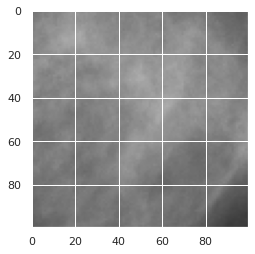

In [6]:
plt.imshow(x_train[0])

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [8]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = ResNet50(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
predictions = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Dense(128,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x =  Dropout(0.2)(x)

# predictions = Dense(8, activation='softmax')(x)
model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

(100, 100, 3)
94773248/94765736 [==============================] - 1s 0us/step


In [9]:
train_features[0].shape

(32768,)

In [10]:
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.3,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)
X_test,y_test=test_features,y_test

In [11]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 5476
length y_train: 5476
length X_val: 2347
length y_val: 2347
length X_test: 3354
length y_test: 3354


In [12]:
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier", 
        "XGB Classifier",
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
        ]

zipped_clf = zip(names,classifiers)

In [13]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    
    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)
    
    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    train_confusion_matrix = confusion_matrix(y_train,y_pred_train)
    
    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
    val_confusion_matrix = confusion_matrix(y_val,y_pred_val)
    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    
    
    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(train_accuracy))
    print("F1_score : {}".format(train_F1))
    print("Cohen Kappa Score : {} ".format(train_kappa))
    print("Recall : {}".format(train_recall))
    print("Precision : {}".format(train_precision))
    print("Confusion Matrix :\n {}".format(train_confusion_matrix))
    
    print()
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(val_accuracy))
    print("F1_score : {}".format(val_F1))
    print("Cohen Kappa Score : {} ".format(val_kappa))
    print("Recall : {}".format(val_recall))
    print("Precision : {}".format(val_precision))
    print("Confusion Matrix :\n {}".format(val_confusion_matrix))
    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

In [14]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf): 
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print("Fitting {} on features ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [15]:
classifier_comparator(x_train_acc,y_train_acc,x_val_acc,y_val_acc,X_test,y_test,classifier=zipped_clf)

Fitting K Nearest Neighbour Classifier on features 

------------------------ Train Set Metrics------------------------

accuracy : 91.02%
F1_score : 0.8982
Cohen Kappa Score : 0.5109 
Recall : 0.9102
Precision : 0.9026
Confusion Matrix :
 [[4676   80]
 [ 412  308]]

------------------------ Validation Set Metrics------------------------

accuracy : 88.62%
F1_score : 0.867
Cohen Kappa Score : 0.3496 
Recall : 0.8862
Precision : 0.868
Confusion Matrix :
 [[1990   49]
 [ 218   90]]

------------------------ Test Set Metrics------------------------

accuracy : 88.25%
F1_score : 0.8657
Cohen Kappa Score : 0.3644 
Recall : 0.8825
Precision : 0.8643
Confusion Matrix : [[2816   87]
 [ 307  144]]
--------------------------------------------------------------------------------

Fitting SVM on features 

------------------------ Train Set Metrics------------------------

accuracy : 93.10000000000001%
F1_score : 0.9207
Cohen Kappa Score : 0.6164 
Recall : 0.931
Precision : 0.9341
Confusion Matrix

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

------------------------ Train Set Metrics------------------------

accuracy : 100.0%
F1_score : 1.0
Cohen Kappa Score : 1.0 
Recall : 1.0
Precision : 1.0
Confusion Matrix :
 [[4756    0]
 [   0  720]]

------------------------ Validation Set Metrics------------------------

accuracy : 90.53999999999999%
F1_score : 0.8931
Cohen Kappa Score : 0.486 
Recall : 0.9054
Precision : 0.8958
Confusion Matrix :
 [[1998   41]
 [ 181  127]]

------------------------ Test Set Metrics------------------------

accuracy : 90.82000000000001%
F1_score : 0.8969
Cohen Kappa Score : 0.5168 
Recall : 0.9082
Precision : 0.9001
Confusion Matrix : [[2847   56]
 [ 252  199]]
--------------------------------------------------------------------------------



In [16]:
ann=Sequential()
ann.add(Dense(16,activation='relu',input_shape=x_train_acc[0].shape))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))

ann.summary()

ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(x_train_acc, y_train_acc,validation_data=(x_val_acc,y_val_acc), epochs=20)

loss_value , accuracy = ann.evaluate(x_train_acc, y_train_acc)
print('Train_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(x_val_acc, y_val_acc)
print('Validation_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(X_test, y_test)
print('test_accuracy = ' + str(accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                524304    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [17]:
y_pred=ann.predict_classes(X_test)
target=["B","M"]
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.9135
Precision: 0.9066
Recall: 0.9135
F1 Score: 0.9073
Cohen Kappa Score: 0.578
		Classification Report:
               precision    recall  f1-score   support

           B       0.93      0.97      0.95      2903
           M       0.75      0.54      0.63       451

    accuracy                           0.91      3354
   macro avg       0.84      0.75      0.79      3354
weighted avg       0.91      0.91      0.91      3354

